In [1]:
%pylab inline
import os
import sys
sys.path.insert(0, "..")
import scipy.ndimage
import imcut
from imcut import pycut


Populating the interactive namespace from numpy and matplotlib


# Prepare the image

In [2]:
def make_data(sz=32, offset=0, sigma=80):
    seeds = np.zeros([sz, sz, sz], dtype=np.int8)
    seeds[offset + 12, offset + 9:offset + 14, offset + 10] = 1
    seeds[offset + 20, offset + 18:offset + 21, offset + 12] = 1
    img = np.ones([sz, sz, sz])
    img = img - seeds

    seeds[
        offset + 3:offset + 15, 
        offset + 2:offset + 6, 
        offset + 27:offset + 29] = 2
    img = scipy.ndimage.morphology.distance_transform_edt(img)
    segm = img < 7
    img = (100 * segm + sigma * np.random.random(img.shape)).astype(np.uint8)
    return img, segm, seeds

# Perform the segmentation

In [3]:
img, seg, seeds = make_data(64, 20)
segparams = {
    # 'method':'graphcut',
    'method': 'graphcut',
    'use_boundary_penalties': False,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'modelparams': {
        'type': 'gmmsame',
        'params': {
            "n_components": 2
        }
        # 'fv_type': "fv_extern",
        # 'fv_extern': fv_function,
        # 'adaptation': 'original_data',
    }
}
gc = pycut.ImageGraphCut(img , segparams=segparams)
gc.set_seeds(seeds)

gc.run()



# Show the estimated intensity model

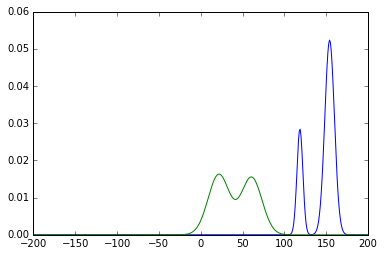

In [4]:
f = gc.show_model(start=-200, stop=200, show=False)

# Show the likelihood and the real distribution of the data intensity

tdata1 max  3660  min  0  dtype  int32
tdata2 max  488  min  0  dtype  int32


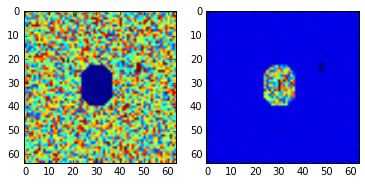

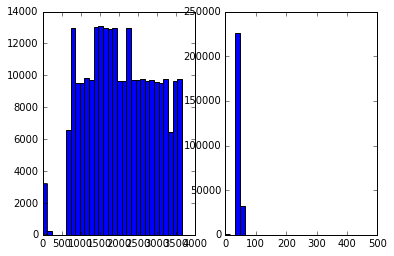

In [5]:
f = gc.show_similarity(show=False, bins=30)

# See model parameters

In [6]:
gc.mdl.mdl

{1: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=2, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None),
 2: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=2, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None)}

In [7]:
gc.mdl.mdl[1].means_

array([[ 153.99999748],
       [ 118.49999917]])

In [8]:
gc.mdl.mdl[2].means_

array([[ 60.70513739],
       [ 21.56915911]])

In [13]:
gc.mdl.mdl[2].covariances_

array([[[ 157.11749943]],

       [[ 161.40230352]]])

# Documentation

In [9]:
help(imcut.pycut.ImageGraphCut)

Help on class ImageGraphCut in module imcut.pycut:

class ImageGraphCut(builtins.object)
 |  Interactive Graph Cut.
 |  
 |  ImageGraphCut(data, zoom, modelparams)
 |  scale
 |  
 |  Example:
 |  
 |  igc = ImageGraphCut(data)
 |  igc.interactivity()
 |  igc.make_gc()
 |  igc.show_segmentation()
 |  
 |  Methods defined here:
 |  
 |  __init__(self, img, modelparams={}, segparams={}, voxelsize=[1, 1, 1], debug_images=False, volume_unit='mm3', interactivity_loop_finish_fcn=None)
 |      Args:
 |          img: input data
 |          modelparams: parameters of model
 |          segparams: segmentation parameters
 |              use_apriori_if_available - set self.apriori to ndimage with same shape as img
 |              apriori_gamma: influence of apriory information. 0 means no influence, 1.0 is 100% use of
 |              apriori information
 |          voxelsize: size of voxel
 |          debug_images: use to show debug images with matplotlib
 |          volume_unit: define string of v

In [10]:
import imcut.models
help(imcut.models.Model3D)

Help on class Model3D in module imcut.models:

class Model3D(builtins.object)
 |  Model for image intensity. Last dimension represent feature vector.
 |  m = Model()
 |  m.train(cla, clb)
 |  X = numpy.random.random([2,3,4])
 |  # we have data 2x3 with fature vector with 4 fatures
 |  m.likelihood(X,0)
 |  
 |  modelparams['type']: type of model estimation. Gaussian mixture from EM
 |  algorithm is implemented as 'gmmsame'. Gaussian kernel density estimation
 |  is implemented as 'gaussian_kde'. General kernel estimation ('kernel')
 |  is from scipy version 0.14 and it is not tested.
 |  
 |  fv_type: feature vector type is defined with one of fallowing string
 |      intensity - based on seeds and data the intensity as feature vector is used
 |      voxel - information in voxel1 and voxel2 is used
 |      fv_extern - external feature vector function specified in fv_extern label
 |      fv001 - pixel and gaussian blur
 |  
 |  fv_extern:
 |      function `fv_function(data, voxelsize, s